# Libraries and modules imports

In [1]:
%load_ext autoreload
%autoreload 2

import torch 
print('Pytorch version :', torch.__version__)

from Class_PINN import PINN
from Class_CollocationPoints import CollocationPoints
from Class_ObservationPoints import ObservationPoints
from Backwater_model import J, compute_ref_solution
import display

Pytorch version : 2.1.2


# Cuda setup

In [2]:
# Device choice
use_GPU = True #Choose whether you want to use your GPU or not

if (torch.cuda.is_available() and use_GPU):
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(f'Running on {device} !')

#Additional info when using cuda
if (device.type == 'cuda'):
    print('GPU :', torch.cuda.get_device_name(0))
    print('Total memory :', 
          round(torch.cuda.get_device_properties(0).total_memory/1024**3, 1), 'GB')

#Set default usage to CPU or GPU
torch.set_default_device(device)

Running on cuda !
GPU : NVIDIA RTX A500 Laptop GPU
Total memory : 3.8 GB


# $k_{true}$ definition

In [3]:
k_true = torch.tensor([45, 38, 28, 22, 30, 45, 60, 75]) #You can modify the value of k_true here !

# Collocation points definition

In [4]:
col = CollocationPoints(device, 
                        random = False, #Choose between grid collocation points (=True) and random collocation points (=False)
                        N_col = 100, #Choose number of collocation points
                        variable_boundaries = (0, 1000), #Choose the boundaries of the domain
                        test_size = 0, #Choose the testing set / training set ratio
                        seed = 0) #Set the seed to any integer number for reproductible randomness

# PINN definition

In [5]:
model = PINN(device, col = col,
             layers = [1, 40, 1], #Choose the neural network architecture
             k_0 = 40*torch.ones_like(k_true), #Choose the initialization value for k
             k_ref = 40, #Choose the reference value for scaling k
             k_interpolation = 'P1', #Choose the interpolation method for the k function (P1 or P0)
             seed = 0) #Set the seed to any integer number for reproductible randomness

# Reference solution and Observations generation

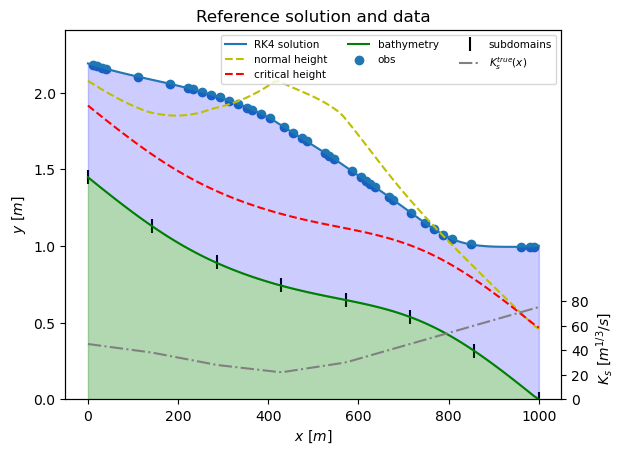

In [6]:
ref_solution = compute_ref_solution(model, col, k = k_true, dx = 10) 

obs = ObservationPoints(ref_solution, 
                        N_obs = 40, #Choose the number of observations in the domain
                        noise_std = 0, #Choose the standard deviation of the white noise added to the observations
                        seed = None) #Set the seed to any integer number for reproductible randomness

display.display_data(model, col, ref_solution, obs) 

# Model training 

##################################################
Processing iteration 50 (iter + eval = 63)
-------------------------
J           = 4.48e-03 (residual : 0.00e+00, BC : 4.44e-03, obs : 4.44e-05)
||grad(J)|| = 5.15e-02
parameter      = tensor([40., 40., 40., 40., 40., 40., 40., 40.], device='cuda:0')
time           = 1.01 s
-------------------------
GPU : NVIDIA RTX A500 Laptop GPU
Total memory         : 3.8 GB
Max Allocated memory : 0.0 GB
Allocated memory     : 0.0 GB
Reserved memory        : 0.0 GB
##################################################
Processing iteration 100 (iter + eval = 127)
-------------------------
J           = 1.16e-04 (residual : 0.00e+00, BC : 1.16e-04, obs : 1.69e-07)
||grad(J)|| = 3.68e-03
parameter      = tensor([40., 40., 40., 40., 40., 40., 40., 40.], device='cuda:0')
time           = 1.58 s
-------------------------
GPU : NVIDIA RTX A500 Laptop GPU
Total memory         : 3.8 GB
Max Allocated memory : 0.0 GB
Allocated memory     : 0.0 GB
Reserved memory 

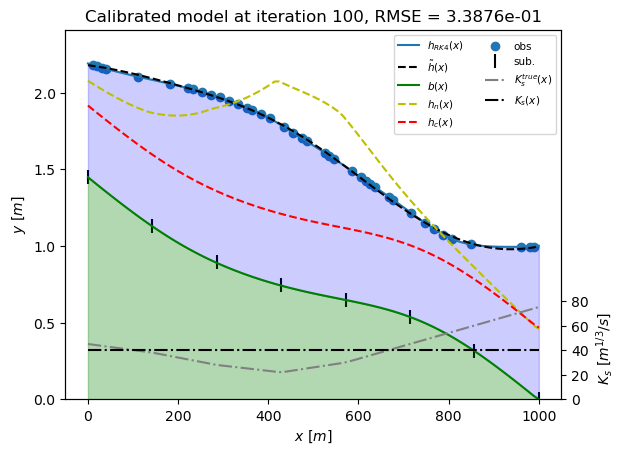

##################################################
Processing iteration 150 (iter + eval = 187)
-------------------------
J           = 1.14e-04 (residual : 9.41e-06, BC : 1.04e-04, obs : 6.72e-07)
||grad(J)|| = 2.66e-03
parameter      = tensor([51.4616, 35.6161, 27.0748, 22.8532, 28.2924, 47.2220, 58.3863, 50.8500],
       device='cuda:0')
time           = 2.18 s
-------------------------
GPU : NVIDIA RTX A500 Laptop GPU
Total memory         : 3.8 GB
Max Allocated memory : 0.0 GB
Allocated memory     : 0.0 GB
Reserved memory        : 0.0 GB
##################################################
Processing iteration 200 (iter + eval = 417)
-------------------------
J           = 1.09e-04 (residual : 4.19e-06, BC : 1.04e-04, obs : 4.44e-07)
||grad(J)|| = 1.55e-04
parameter      = tensor([60.2442, 33.7464, 27.1993, 23.0676, 27.5983, 47.5974, 56.2300, 78.3573],
       device='cuda:0')
time           = 3.40 s
-------------------------
GPU : NVIDIA RTX A500 Laptop GPU
Total memory         : 3.8

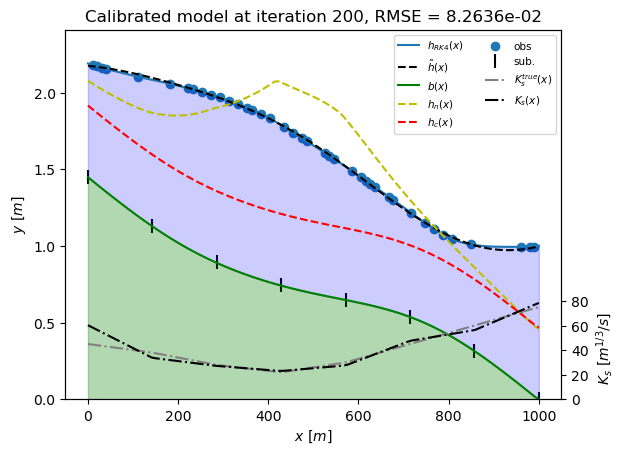

##################################################
Processing iteration 250 (iter + eval = 628)
-------------------------
J           = 1.14e-04 (residual : 3.86e-06, BC : 1.03e-04, obs : 6.65e-06)
||grad(J)|| = 5.12e-02
parameter      = tensor([56.6228, 34.3724, 27.0646, 23.1254, 27.7589, 47.3125, 55.7382, 79.9498],
       device='cuda:0')
time           = 4.98 s
-------------------------
GPU : NVIDIA RTX A500 Laptop GPU
Total memory         : 3.8 GB
Max Allocated memory : 0.0 GB
Allocated memory     : 0.0 GB
Reserved memory        : 0.0 GB
##################################################
Processing iteration 300 (iter + eval = 857)
-------------------------
J           = 1.14e-04 (residual : 3.85e-06, BC : 1.03e-04, obs : 7.05e-06)
||grad(J)|| = 5.34e-02
parameter      = tensor([56.6962, 34.3423, 27.0272, 23.0810, 27.7228, 47.4248, 55.5269, 80.2487],
       device='cuda:0')
time           = 6.20 s
-------------------------
GPU : NVIDIA RTX A500 Laptop GPU
Total memory         : 3.8

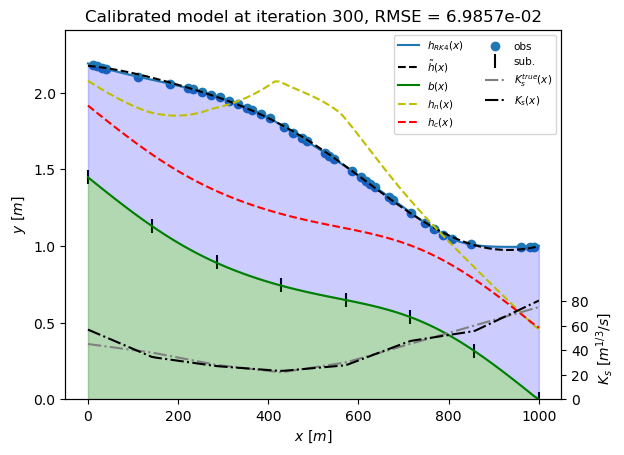

In [7]:
model.train_model(J, col, obs, ref_solution, 
                  normalize_J = True, #Choose whether you want to normalize J by J_0 or not
                  pre_train_iter = 100, #Choose the number of iterations for pre-training
                  alter_steps = 4, #Choose the number of alternating minimization steps
                  alter_freq = (40, 10), #Choose the number of iterations on theta (first value) and on k (second value) for each step
                  display_freq = (50, 100)) #Choose the display frequency for the training informations (first value) and the results plot (second value)

# Display training and results

##################################################
Final parameter RMSE : 6.99e-02
Final variable RMSE : 1.05e-02
##################################################


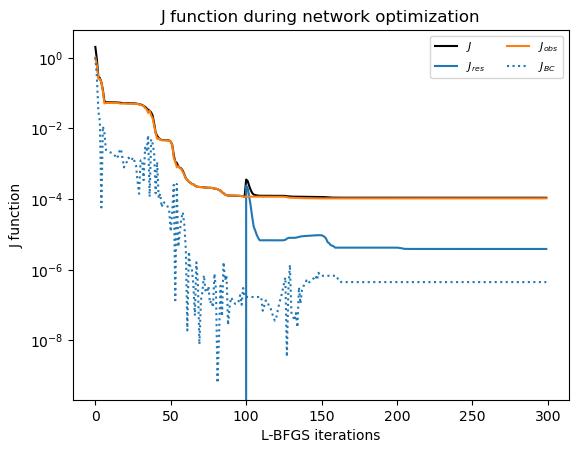

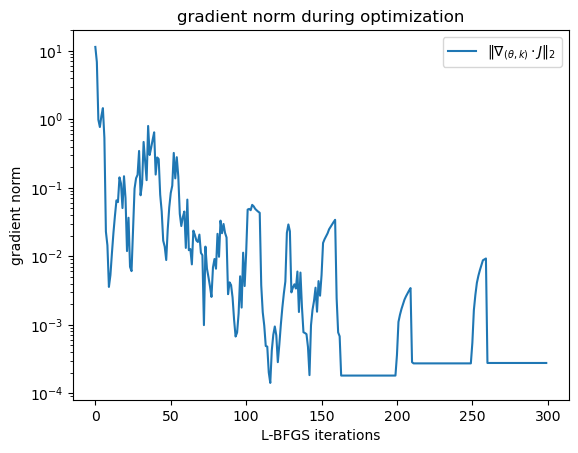

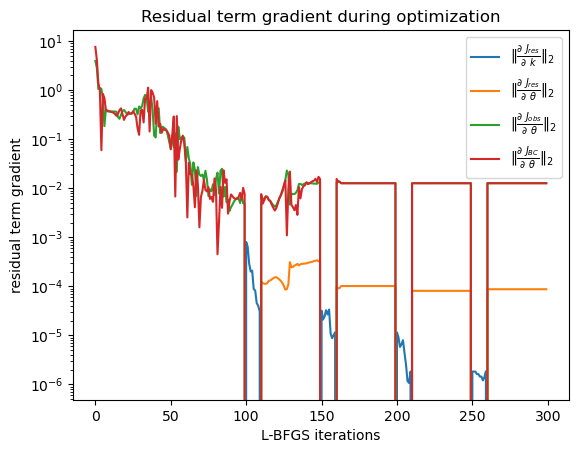

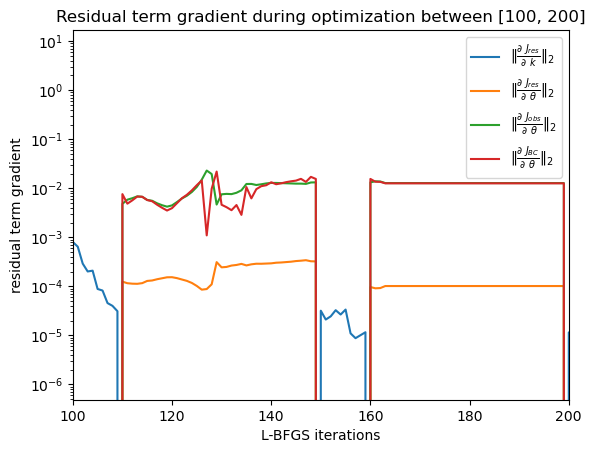

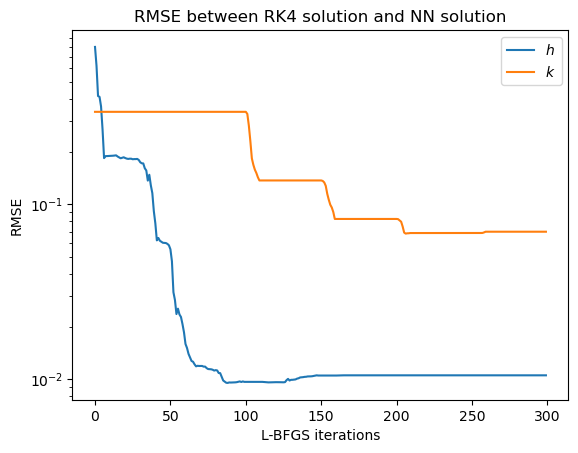

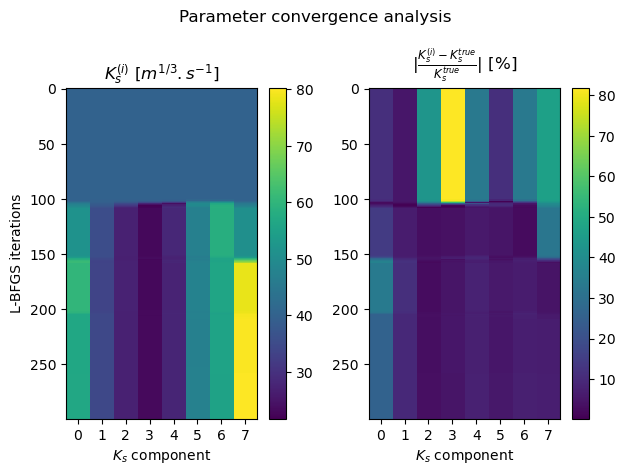

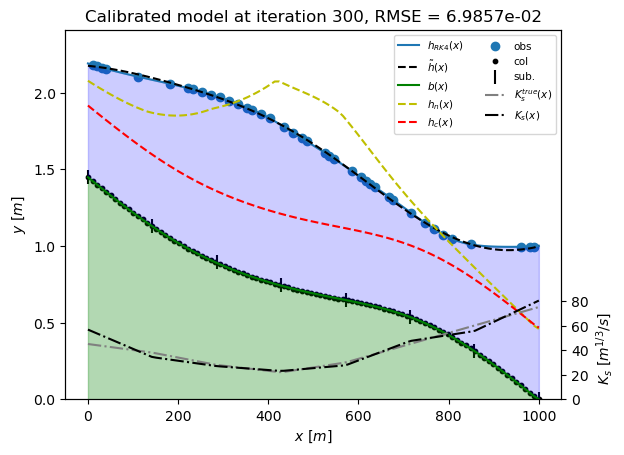

In [8]:
display.display_training(model, col, ref_solution)

display.display_results(model, col, ref_solution, obs, plot_col = True)